<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Chapter%2015%20-%20Processing%20Sequences%20Using%20RNNs%20and%20CNNs/05_multistep_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FORECASTING SEVERAL STEP AHEAD**

In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN

In [2]:
## define a function to generate time series
def generate_time_series(batch_size, n_steps):
  """ Function Returns a Numpy array of shape [batch_size, time steps, 1]
      Series is a sum of two sine waves of fixed amplitudes.
      But random frequencies and phases, plus some noise.
      :param :- batch_size : number of data points.
      :param :- n_steps :- number of steps.
  """
  freq1, freq2, offset1, offset2 = np.random.randn(4, batch_size, 1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
  series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
  series += 0.1 * np.sin(np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

In [4]:
## define the sequence data, time series data.
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(X_train.shape)  ## [batch_size, time steps, dimensionality]
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7000, 50, 1)
(7000, 1)
(2000, 50, 1)
(2000, 1)
(1000, 50, 1)
(1000, 1)


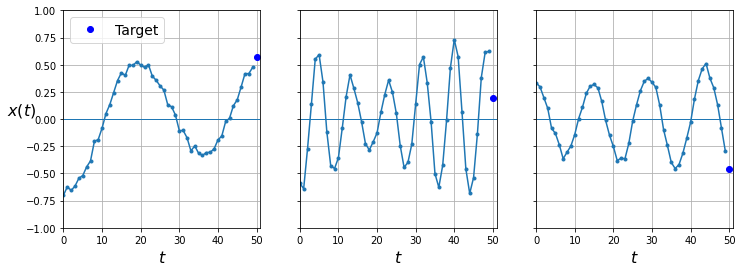

In [13]:
## plot the series
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

## plotting validation set graph.

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [5]:
## Deep RNN with three layers.
## including two hidden layer.
## one output layer.
## return sequneces = True or the layers of hidden layers.
## bcz in keras, rnn layers will only return the final output.
## to make them return one output per time step.
## set return_sequences = True.
## by using the Dense layer, seems that model converges faster than simple RNN layer.
## and also if we want to change the default "tanh" activation function.
## we can use the Dense Layer.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [6]:
## compile the model
model.compile(
    loss = "mse",
    optimizer = "adam"
)

In [16]:
## train the model
r = model.fit(X_train, y_train,
              validation_data = (X_valid, y_valid),
              epochs = 20)

Epoch 1/20
219/219 [==============================] - 9s 28ms/step - loss: 0.0477 - val_loss: 0.0138
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0063 - val_lo

In [17]:
n_steps = 50
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
# print(Y_pred)

1/1 [==============================] - 0s 33ms/step


In [18]:
Y_pred.shape  ## 10 means 10 step prediction, or forecasting.

(1, 10, 1)

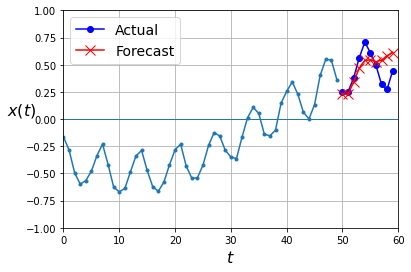

In [19]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show();

The result shows that the Multi Step Forecast using the Deep Simple RNN model.
Which we were used the Dense Layer.

But with the Model, we wil be only doing the Forecast for Next Step

***